<a href="https://colab.research.google.com/github/StillWork/book6/blob/master/gh_03_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**3장 – 분류**

_hands_on 3장의 모든 샘플 코드와 연습 문제 정답을 담고 있습니다._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/handson-ml2/blob/master/03_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

# 설정

In [0]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST

In [0]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [0]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [0]:
y.shape

(70000,)

In [0]:
28 * 28

784

그림 저장: some_digit_plot


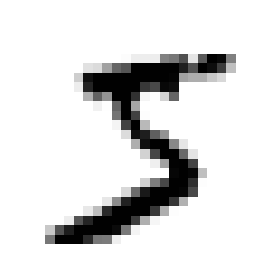

In [0]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [0]:
y[0]

'5'

In [0]:
y = y.astype(np.uint8)

In [0]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [0]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

그림 저장: more_digits_plot


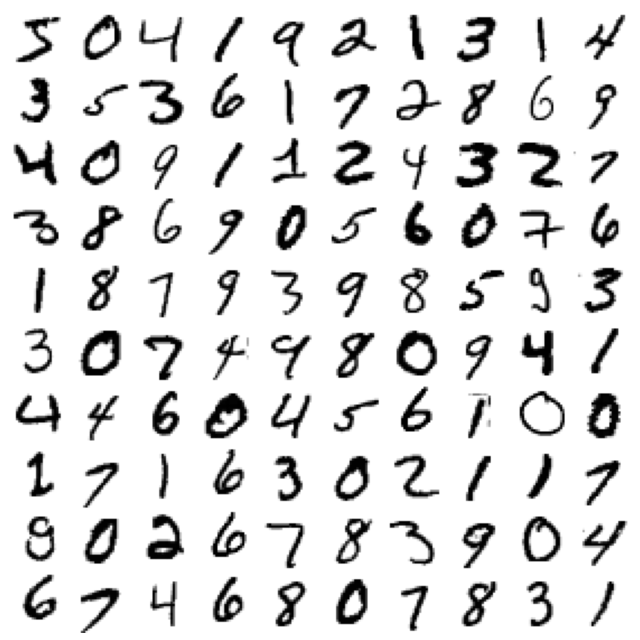

In [0]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [0]:
y[0]

5

In [0]:

# X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
X_train, X_test, y_train, y_test = X[:1000], X[1000:], y[:1000], y[1000:]

# 이진 분류기
- "5"와 "5가 아닌것" 두 부류를 분류하는 작업의 이진분류기를 만들어보겠다
- 아래에서 5는 True로 나머지 숫자는 모두 False로 바꾼다

In [0]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

**노트**: `max_iter`와 `tol` 같은 일부 매개변수는 사이킷런 다음 버전에서 기본값이 바뀝니다. 버전이 업데이트되더라도 결과가 바뀌지 않도록 아예 나중에 바뀔 기본값을 사용해 명시적으로 지정하겠습니다. 번거로움을 피하기 위해 책에는 따로 표시하지 않았습니다.

In [0]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
sgd_clf.predict([some_digit])

array([ True])

In [0]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.94610778, 0.91591592, 0.90690691])

- clone: 모델의 파라미터를 복사한다

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# shuffle=False가 기본값이기 때문에 random_state를 삭제하던지 shuffle=True로 지정하라는 경고가 발생합니다.
# 0.24버전부터는 에러가 발생할 예정이므로 향후 버전을 위해 shuffle=True을 지정합니다.
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9550898203592815
0.93993993993994
0.9519519519519519


- 무조건 "5가 아님"으로 이진분류 모델을 만들어본다. 정확도가 90%가 나올 것이다

In [0]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [0]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91916168, 0.9039039 , 0.9009009 ])

- 테스트 데이터를 사용하지 않고 검증하기 위해서 cross_val_predict를 사용한다
- 자체적으로 "검증" 데이터를 사용하여 훈련에 사용하지 않은 데이터에 대한 예측치를 얻는다 (깨끗한..)

In [0]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

- 행은 실제값을, 열은 예측값을 나타낸다
- 아래에서 (0, 0) 항목은 5가 아니라고 제대로 분류한 것
- 아래에서 (0, 1) 항목은 5라고 잘 못 분류한 횟수이다

In [0]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[862,  46],
       [ 31,  61]])

- 예측값에 실제값을 넣어보겠다 (완벽한 분류기로 가정)

In [0]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[908,   0],
       [  0,  92]])

In [0]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.5700934579439252

In [0]:
recall_score(y_train_5, y_train_pred)

0.6630434782608695

In [0]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.6130653266331658

### 정밀도-재현률 트레이드오프가 있다
### decision-function을 사용하여 각 샘플을 분류하는데 사용한 점수(score)를 계산할 수 있다

- 어떤 숫자(5)에 대한 점수 보기

In [0]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([602740.47217499])

In [0]:
threshold = 0 # 임의의 값
y_some_digit_pred = (y_scores > threshold)

In [0]:
y_some_digit_pred

array([ True])

In [0]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [0]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [0]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

그림 저장: precision_recall_vs_threshold_plot


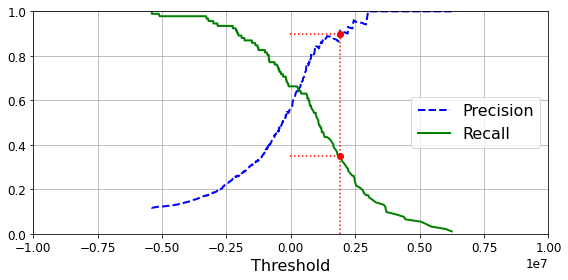

In [0]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-10000000, 10000000, 0, 1])             # Not shown
#   plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

In [0]:
(y_train_pred == (y_scores > 0)).all()

True

### knee 포인트를 선택할 수 있다
- 또는 최대의 f1 점수를 얻도록 할 수도 있다
- 또는 특정한 정밀도 이상을 지정할 수도 있다
- argmax() 사용


그림 저장: precision_vs_recall_plot


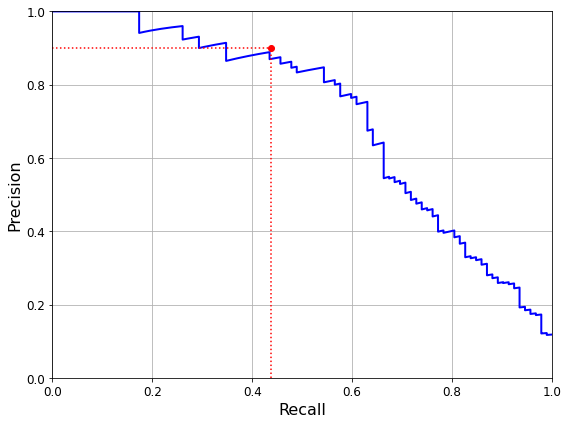

In [0]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [0]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [0]:
threshold_90_precision

1916016.1799683466

In [0]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [0]:
precision_score(y_train_5, y_train_pred_90)

0.9142857142857143

In [0]:
recall_score(y_train_5, y_train_pred_90)

0.34782608695652173

# ROC 곡선

In [0]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

그림 저장: roc_curve_plot


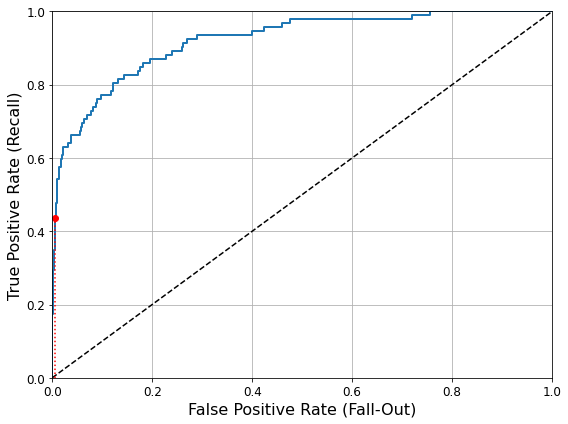

In [0]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
save_fig("roc_curve_plot")                         # Not shown
plt.show()

In [0]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9208245546830109

**노트**: 사이킷런 0.22 버전에서 바뀔 기본 값을 사용해 `n_estimators=100`로 지정합니다.

- 랜덤 포레스트에서는 predect_proba() 함수를 제공한다 (선형 계열 모델에서는 점수를, 앙상블 모델에서는 확률을 알려준다)

In [0]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [0]:
y_scores_forest = y_probas_forest[:, 1] # 점수 = 양성 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

그림 저장: roc_curve_comparison_plot


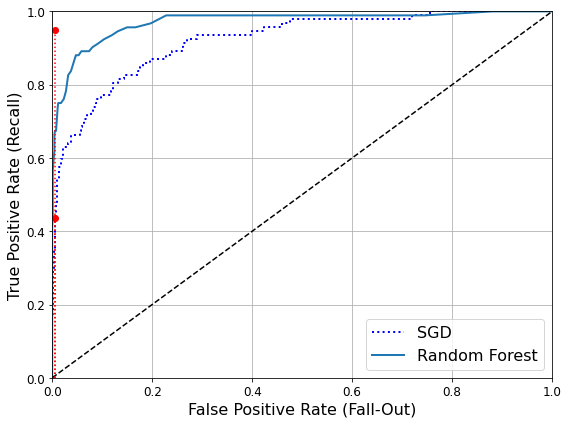

In [0]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [0]:
roc_auc_score(y_train_5, y_scores_forest)

0.9714554204175446

In [0]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

1.0

In [0]:
recall_score(y_train_5, y_train_pred_forest)

0.31521739130434784

# 다중 분류
- SGD 분류기, 랜덤 포레스트, 나이브 베이즈는 다중분류를 직접 처리할 수 있다
- 로지스틱 회귀, SVM은 이진 분류만 가능하다

In [0]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train_5이 아니라 y_train입니다
svm_clf.predict([some_digit])

array([5], dtype=uint8)

- 내부에서는 One versus One (OVO) 전략을 사용하여 10개의 이진 분류 작업을 수행한다
- 따라서 10개의 점수를 얻는다

In [0]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [0]:
np.argmax(some_digit_scores)

5

- 아래 클래스명은 특별히 0, 1, 2, 등이 들어있다

In [0]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [0]:
svm_clf.classes_[5]

5

- 다중 분류시 특정한 알고리즘을 지정할 수도 있다.
- 아래는 10개의 내부 분류기가 만들어진 것을 알 수 있다.

In [0]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [0]:
len(ovr_clf.estimators_)

10

- SGD는 다중 분류를 직접 수행할 수 있다
- 10개의 점수를 확인한다

In [0]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [0]:
sgd_clf.decision_function([some_digit])

array([[-6049581.97985829, -6138036.45541781, -3886281.38604606,
         -604692.42366776, -6948311.32017537,   914498.2913215 ,
        -6855666.78647961, -3866146.33271573, -4016434.08430155,
        -3209136.89074954]])

In [0]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.83233533, 0.82882883, 0.79279279])

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.83532934, 0.81681682, 0.82882883])

In [0]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[ 95,   0,   1,   0,   0,   1,   0,   0,   0,   0],
       [  0, 106,   2,   0,   0,   5,   1,   0,   1,   1],
       [  1,   3,  76,   2,   3,   1,   4,   3,   5,   1],
       [  1,   2,   5,  75,   0,   4,   0,   3,   0,   3],
       [  0,   0,   0,   3,  90,   3,   1,   1,   2,   5],
       [  1,   0,   2,   9,   2,  65,   2,   1,   8,   2],
       [  2,   1,   3,   0,   2,   4,  82,   0,   0,   0],
       [  0,   2,   3,   0,   3,   0,   0, 106,   0,   3],
       [  2,   6,   2,   1,   0,   6,   2,   2,  64,   2],
       [  3,   0,   2,   1,   7,   1,   0,  17,   1,  68]])

In [0]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

그림 저장: confusion_matrix_plot


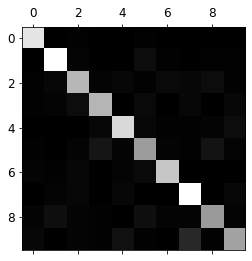

In [0]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

- 클래스마다 분포 (갯수)가 다르므로 상대적인 오류율을 봐야 한다
- 많은 이미지가 '8'로 잘 못 예측된 것을 알 수 있다

In [0]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

그림 저장: confusion_matrix_errors_plot


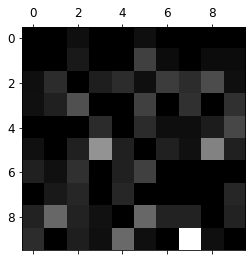

In [0]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

그림 저장: error_analysis_digits_plot


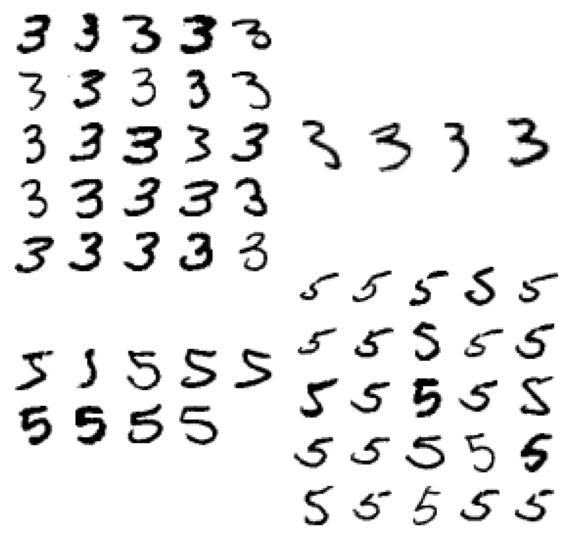

In [0]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

- 선형 분류기에서는 위와 같은 오류가 생기기 쉽다

# 다중 레이블 분류
- y 가 여러개의 이진 분류를 동시에 수행하는 경우
- 7 이상인 숫자를 찾거나
- 홀수를 찾는 문제


In [0]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

- 5는 7보다 작고, 홀수이다

In [0]:
knn_clf.predict([some_digit])

array([[False,  True]])

**경고**: 다음 셀은 실행하는데 매우 오래 걸립니다(하드웨어에 따라 몇 시간이 걸릴 수 있습니다).

- 모든 숫자에 대해서 f1 점수를 구하여 평가할 수 있디

In [0]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.8885424739016866

## 다중 출력 분류
- 노이지를 제거하는 모델 만들기
- 노이지가 없는 이미지로 학습을 시킨다

In [0]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

그림 저장: noisy_digit_example_plot


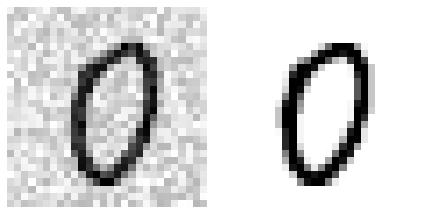

In [0]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

그림 저장: cleaned_digit_example_plot


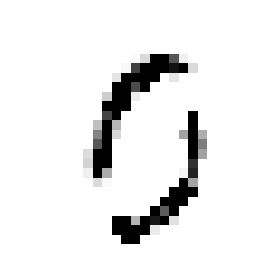

In [0]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")